[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1KsD8X9sjJ_JaoSAgiboVsbt-sunVNpDu)


** Load Pre-trained weights**



The Pretrained network used is mobilenetv2 trained on imagenet. The feature wts excluding the last layer are available from 'https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/feature_vector/2.tar.gz' which are downloaded to google Drive.

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import numpy as np

In [4]:
######################mount drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
! mkdir "/content/gdrive/My Drive/mobilenet_wts"

mkdir: cannot create directory ‘/content/gdrive/My Drive/mobilenet_wts’: File exists


**Download Weights from tensrflow hub and save the parameters to a checkpoint file**


In [6]:
!wget 'https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/feature_vector/2.tar.gz' -P /content/gdrive/My\ Drive/mobilenet_wts


--2020-01-04 20:35:07--  https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/feature_vector/2.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8485069 (8.1M) [application/x-tar]
Saving to: ‘/content/gdrive/My Drive/mobilenet_wts/2.tar.gz.2’

2.tar.gz.2          100%[===================>]   8.09M  51.2MB/s    in 0.2s    

2020-01-04 20:35:07 (51.2 MB/s) - ‘/content/gdrive/My Drive/mobilenet_wts/2.tar.gz.2’ saved [8485069/8485069]



In [7]:
!tar -C /content/gdrive/My\ Drive/mobilenet_wts -zxvf /content/gdrive/My\ Drive/mobilenet_wts/2.tar.gz

./
./assets/
./saved_model.pb
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001


**Load checkpoint file from the Google Drive and use it for predicting**


In [0]:
path = F"/content/gdrive/My Drive/mobilenet_wts/"
reload_wts = tf.keras.models.load_model(path,custom_objects={'KerasLayer': hub.KerasLayer})

In [9]:
IMG_SIZE=224
feature_extractor = hub.KerasLayer(reload_wts,input_shape=(IMG_SIZE, IMG_SIZE,3))
feature_extractor.trainable = False
model = tf.keras.Sequential([feature_extractor, layers.Dense(3, activation='softmax')])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


**Dataset selected for prediction is "rock paper scissor" from tensorflow hub**

In [0]:
import tensorflow_datasets as tfds
splits=tfds.Split.TRAIN.subsplit([80,20])
(train,val), info =tfds.load('rock_paper_scissors',with_info=True, as_supervised=True, split=splits)
test = tfds.load("rock_paper_scissors", split=tfds.Split.TEST, as_supervised=True)

In [11]:
print(info.features['label'])

ClassLabel(shape=(), dtype=tf.int64, num_classes=3)


In [12]:
def dataset_length(dataset):
    count = 0
    for image in dataset:
        count += 1
    return count

print(dataset_length(test)) # 372
print(dataset_length(val)) # 500
print(dataset_length(train)) # 2020

372
500
2020


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0
  return image, label
train_batches=train.shuffle(dataset_length(train)//4).map(format_image).batch(32).prefetch(1)
val_batch=val.map(format_image).batch(32).prefetch(1)
test_batch=test.map(format_image).batch(32).prefetch(1)

**Train the model on the dataset**

In [14]:
EPOCHS = 6
history = model.fit(train_batches, epochs=EPOCHS, validation_data=val_batch)

Epoch 1/6
64/64 [==============================] - 13s 209ms/step - loss: 0.3755 - accuracy: 0.8926 - val_loss: 0.1166 - val_accuracy: 0.9900
Epoch 2/6
64/64 [==============================] - 9s 133ms/step - loss: 0.0702 - accuracy: 0.9980 - val_loss: 0.0534 - val_accuracy: 0.9980
Epoch 3/6
64/64 [==============================] - 9s 134ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 4/6
64/64 [==============================] - 8s 129ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 5/6
64/64 [==============================] - 8s 129ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 6/6
64/64 [==============================] - 8s 131ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000


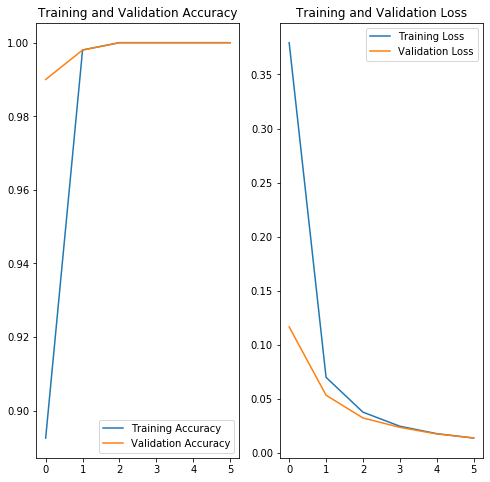

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
class_names = np.array(info.features['label'].names)
class_names

array(['rock', 'paper', 'scissors'], dtype='<U8')

In [17]:
image_batch, label_batch = next(iter(test_batch.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
result_batch = model.predict(image_batch)
predicted_ids = np.argmax(result_batch, axis=-1)
predicted_class_names = class_names[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['scissors', 'rock', 'paper', 'rock', 'scissors', 'scissors',
       'scissors', 'rock', 'rock', 'scissors', 'scissors', 'rock',
       'paper', 'rock', 'rock', 'rock', 'scissors', 'rock', 'rock',
       'paper', 'paper', 'paper', 'rock', 'scissors', 'rock', 'scissors',
       'scissors', 'rock', 'scissors', 'rock', 'rock', 'scissors'],
      dtype='<U8')

In [18]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [2 0 1 0 2 2 2 0 0 2 2 0 1 0 0 0 1 0 0 1 1 1 1 2 1 2 2 0 2 1 0 2]
Predicted labels:  [2 0 1 0 2 2 2 0 0 2 2 0 1 0 0 0 2 0 0 1 1 1 0 2 0 2 2 0 2 0 0 2]


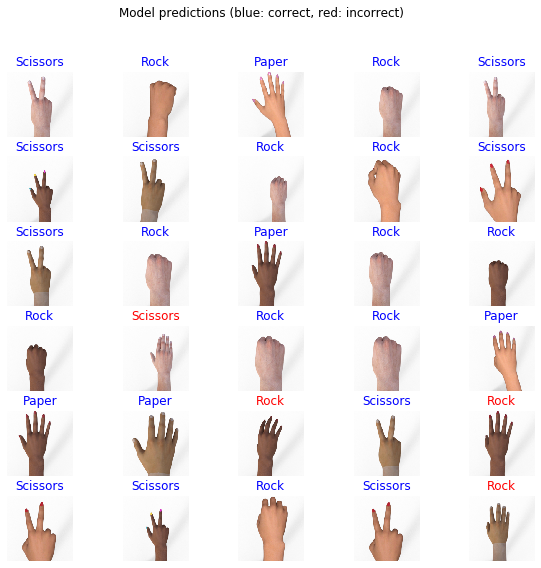

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")